In [132]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from country import County, Party
from ipywidgets import interact
from voting import Nation

%matplotlib notebook

In [123]:
def mandates2017(st_lagues=1.4, area_importance=1.8):
    df = pd.read_excel("tabell.xlsx", skiprows=[0, 1, 2])
    df = df.iloc[:, :4]

    st_lagues = st_lagues

    counties = []
    for _k, row in df.iterrows():
        counties.append(County(name=row[0], population=row[1], area=row[3]))
    County.set_parameters({"st_lagues_factor": st_lagues})
    County.set_parameters({"area_importance": area_importance})
    Party.set_parameters({"st_lagues_factor": st_lagues})

    norway = Nation(counties=copy.deepcopy(counties))
    norway.calc_representatives(method="normal")

    # Read in the votes in each county

    votes_raw = pd.read_excel("tabell.xlsx", sheet_name="stemmer", index=1)
    votes = votes_raw.iloc[:, 1:-1]  # fylker er kolonner, parti er index, stemmer er verdier
    votes.index = votes_raw.iloc[:, 0]
    votes = votes.fillna(value=0, axis=0)

    for county in norway.counties:
        county_votes = votes[county._name]
        county.add_parties([Party(name=county_votes.index[k], votes=p_votes) for k, p_votes in enumerate(county_votes)])

    norway.calc_rep_distribution(method="modified")

    # print(norway.represented_parties())

    return norway.national_mandates_count().sum()

In [129]:
def vary_parameters(area_max=10, st_lagues_max=10):
    res = {}
    st_lagues = np.linspace(1, st_lagues_max, 11)
    st_lagues[1] = 1.4  # Used today
    area_importance = np.linspace(1, area_max, 11)
    area_importance[1] = 1.8  # Used today
    for area in area_importance:
        ll = []
        for st_lague in st_lagues:
            ll.append(mandates2017(st_lagues=st_lague, area_importance=area))

        partier = ll[0].index
        df = pd.DataFrame(index=partier)

        for k, dist in enumerate(ll):
            df[st_lagues[k]] = dist

        mappings = {
            "Arbeiderpartiet": "AP",
            "Fremskrittspartiet": "FRP",
            "Høyre": "H",
            "Kristelig Folkeparti": "KRF",
            "Miljøpartiet De Grønne": "MDG",
            "Rødt": "R",
            "Senterpartiet": "SP",
            "Sosialistisk Venstreparti": "SV",
            "Venstre": "V",
        }

        df.index = [mappings[p] for p in df.index]

        df = df.fillna(value=0)
        res[area] = df
    return res, st_lagues, area_importance

In [130]:
res, st_lagues, area_importance = vary_parameters()

<IPython.core.display.Javascript object>


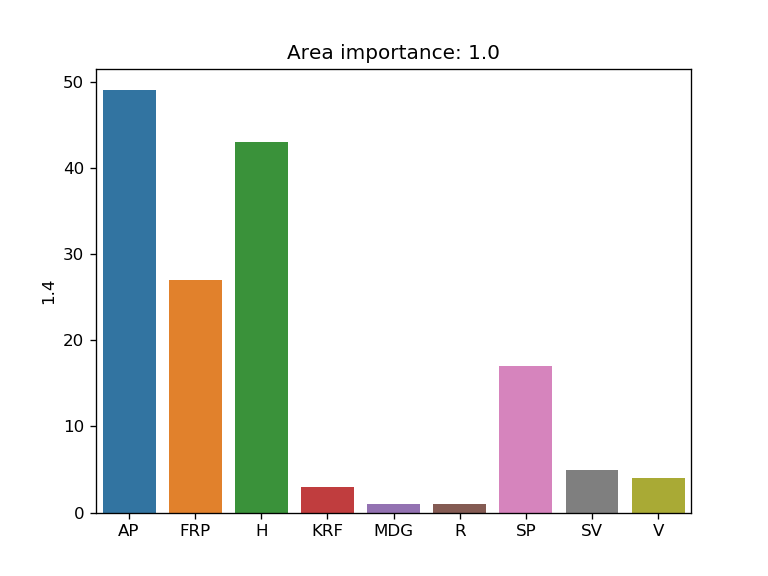

A Jupyter Widget

In [133]:
fig = plt.figure()
ax = fig.add_subplot(111)


@interact(st_lagues=st_lagues, area_importance=area_importance)
def plot_numerical(st_lagues, area_importance) -> None:
    ax.clear()
    plt.title(f"Area importance: {area_importance:.1f}")
    plt.ylabel(f"St Lagües modified factor: {st_lagues}")
    sns.barplot(x=df.index, y=st_lagues, data=res[area_importance])